In [1]:
from adios2toolspy import SuperCell, Particles, Fields
from h5toolspy import H5Processor
from picplot import fieldGrid, histGrid
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

%matplotlib inline 
plt.rcParams['figure.figsize'] = [16, 8]

In [27]:
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-12/Harris/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-12/HarrisBigGridTout/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-12/HarrisNICell/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-15/HarrisOriginalParams/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-17/Harris/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-21/Harris/'
root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_2-9/Harris/'

In [28]:
def averaging(arr, itr=1):
    x, y = arr.shape
    arr = np.pad(arr, ((1,1), (1,1)))
    temp = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            temp[i,j] = (arr[i,j] + arr[i+1,j] + arr[i-1,j] + arr[i,j+1] + arr[i,j-1] + arr[i-1,j-1] + arr[i-1,j+1] + arr[i+1,j-1] + arr[i+1,j+1])/9
    return temp
## do these with np.convolve for better speed np.convolve(x, np.ones(2,2)/4, mode='full')
def fc_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.empty((h,w))
    if dim == 'x':
        for i in range(1,h):
            for k in range(1,w):
                tmp[i,k] = 0.5*(x[i,k] + x[i,k-1]) #x case 2D tmp[x] = 0.25*(x[i,j,k] + x[i,j-1,k] + x[i,j,k-1] + x[i,j-1,k-1]) #x case 3D
            # do in x,y dim for z,  
    elif dim == 'y':
        for i in range(1,h):
            for k in range(1,w):
                tmp[i,k] = 0.25*(x[i,k] + x[i-1,k] + x[i,k-1] + x[i-1,k-1]) # y case
    else:
        for i in range(1,h):
            for k in range(1,w):
                tmp[i,k] = 0.5*(x[i,k] + x[i-1,k]) #x case 3D

    return tmp
## np.convolve(x, np.ones(2,)/2, mode='full', axis=0 or 1)
def ec_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.empty((h,w))
    if dim == 'x':
        for j in range(1,w):
            tmp[:,j] = 0.5*(x[:,j] + x[:,j-1])
    else: # z
        for i in range(1,h):
            tmp[i,:] = 0.5*(x[i,:] + x[i-1,:])
    return tmp

Loading rho_nc_e from File: pfd.002801.xdmf
Loading jx_nc_e from File: pfd.002801.xdmf
Loading jy_nc_e from File: pfd.002801.xdmf
Loading jz_nc_e from File: pfd.002801.xdmf


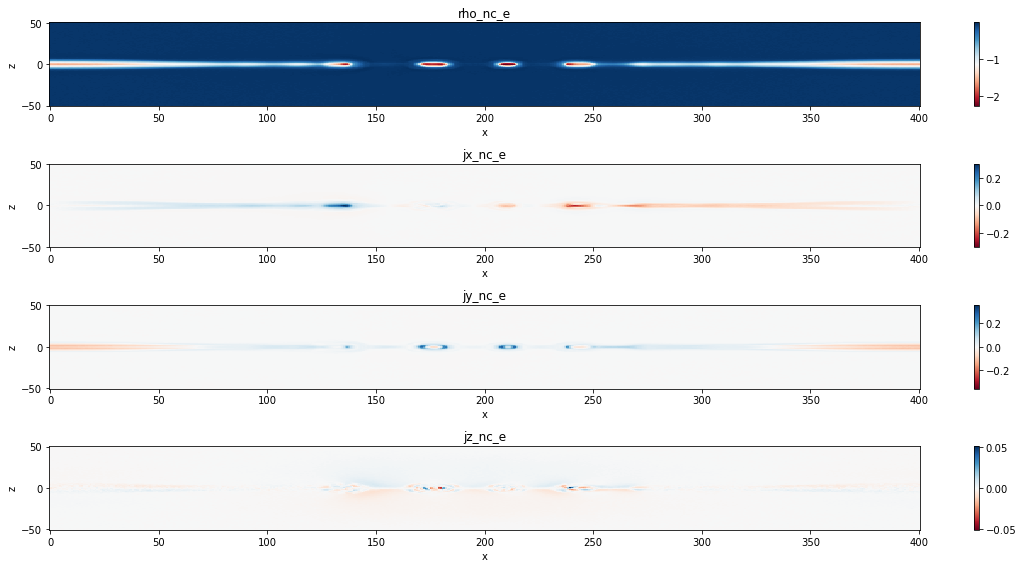

In [94]:
fieldGrid(root, ['rho_nc_e', 'jx_nc_e', 'jy_nc_e', 'jz_nc_e'], [-1], zrange=(None,None), timeAveraged=False)

Loading px_nc_e from File: tfd.002601.xdmf
Loading rho_nc_e from File: tfd.002601.xdmf


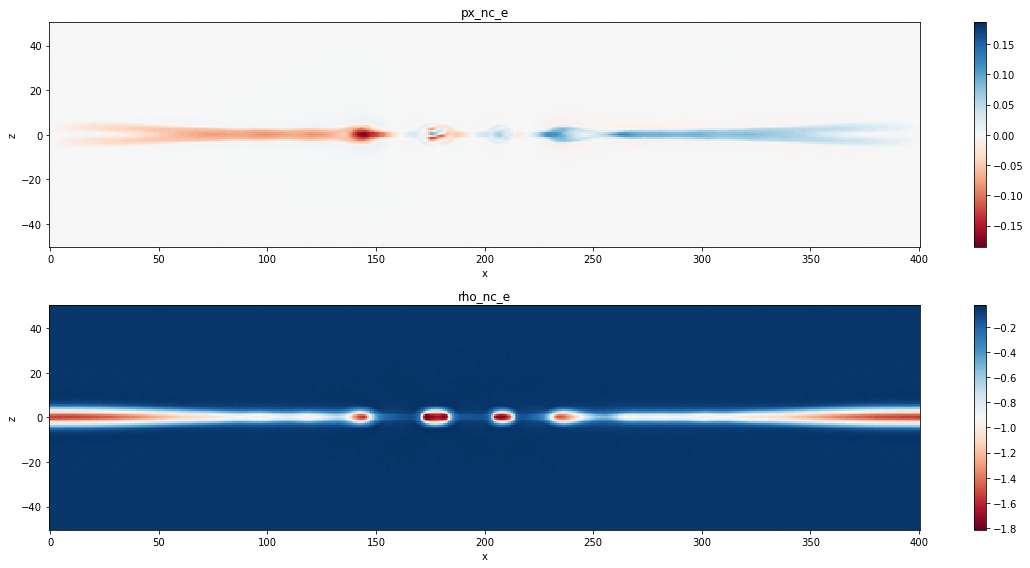

In [52]:
fieldGrid(root, ['px_nc_e', 'rho_nc_e'], [53], zrange=(None,None))

Loading rho_nc_e from File: pfd.002801.xdmf
Loading rho_nc_e from File: pfd.002800.xdmf
Loading jx_nc_e from File: pfd.002801.xdmf
Loading jz_nc_e from File: pfd.002801.xdmf


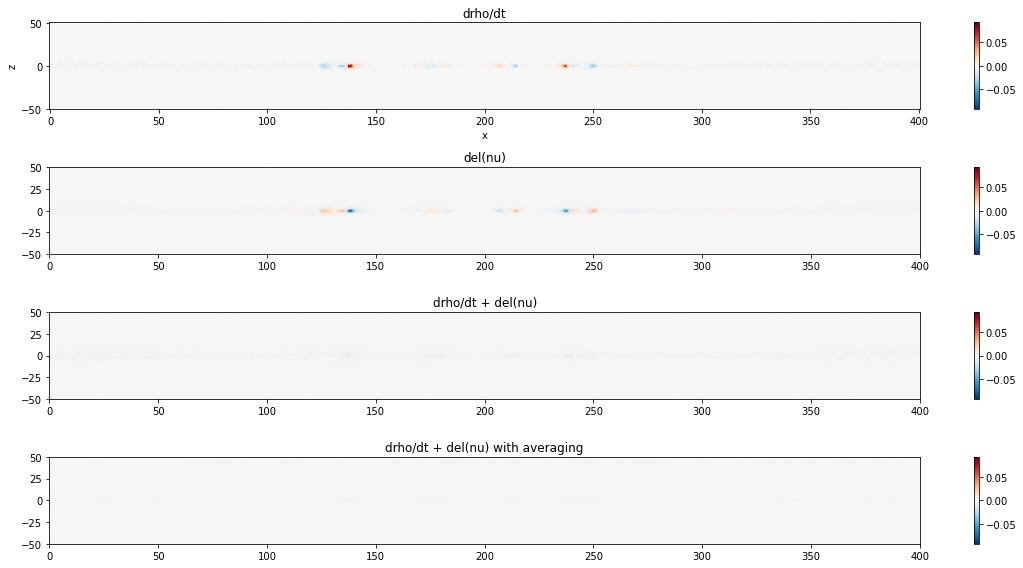

In [104]:
fig, axes = plt.subplots(4,1)
h5p = H5Processor(root, timeAveraged=False)
time = -1
dt = 0.36
field_interval = 1
d_rho_dt = (h5p.getH5Grid('rho_nc_e', time) - h5p.getH5Grid('rho_nc_e', time-1)) / dt

d_rho_dt.plot(ax=axes[0])
axes[0].set_title('drho/dt')
xmax = d_rho_dt.coords['x'].max()
zmax = d_rho_dt.coords['z'].max()

jx = h5p.getH5Grid('jx_nc_e', time)
jz = h5p.getH5Grid('jz_nc_e', time)
dx= 0.78125 #dx/de  80x5/ngridpoints
dy, dz = 5, dx

d_jx_dx = (np.diff(jx.data[:,0,:], axis=1, append=0) + np.diff(jx.data[:,0,:], axis=1, prepend=0))/dx/2
d_jz_dz = (np.diff(jz.data[:,0,:], axis=0, append=0) + np.diff(jz.data[:,0,:], axis=0, prepend=0))/dz/2

xlin = np.linspace(0, xmax, d_jx_dx.shape[1])
zlin = np.linspace(-zmax, zmax, d_jx_dx.shape[0])

del_nu = d_jx_dx + d_jz_dz
pcm1 = axes[1].pcolormesh(xlin, zlin, del_nu, cmap='RdBu_r', shading='gouraud', vmin=-d_rho_dt.max(), vmax=d_rho_dt.max())
fig.colorbar(pcm1, ax=axes[1])
axes[1].set_title('del(nu)')
total = d_rho_dt.data[:,0,:] + del_nu

pcm2 = axes[2].pcolormesh(xlin, zlin, total, cmap='RdBu_r', shading='gouraud', vmin=-d_rho_dt.max(), vmax=d_rho_dt.max())
fig.colorbar(pcm2, ax=axes[2])
axes[2].set_title('drho/dt + del(nu)')

pcm3 = axes[3].pcolormesh(xlin, zlin, averaging(total), cmap='RdBu_r', shading='gouraud', vmin=-d_rho_dt.max(), vmax=d_rho_dt.max())
fig.colorbar(pcm3, ax=axes[3])
axes[3].set_title('drho/dt + del(nu) with averaging')

plt.tight_layout()

Text(0.5, 1.0, 'drho/dt + del(nu) with averaging')

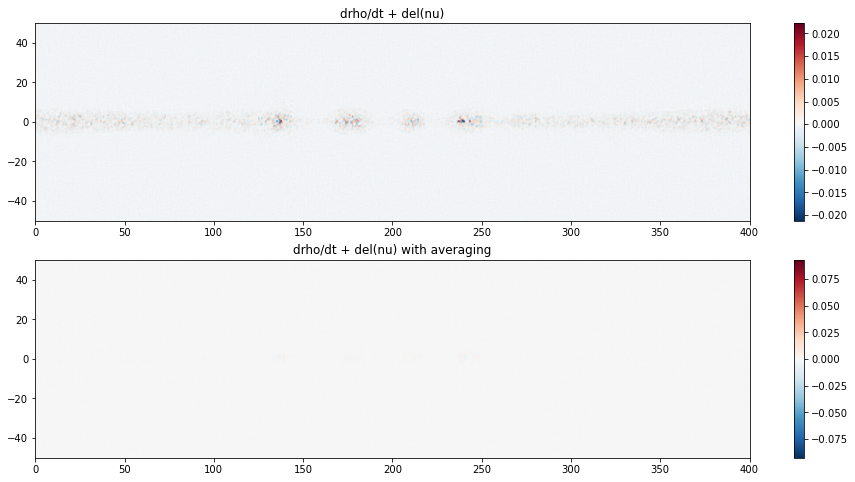

In [105]:
fig, axes = plt.subplots(2,1)

pcm2 = axes[0].pcolormesh(xlin, zlin, total, cmap='RdBu_r', shading='gouraud')
fig.colorbar(pcm2, ax=axes[0])
axes[0].set_title('drho/dt + del(nu)')

pcm3 = axes[1].pcolormesh(xlin, zlin, averaging(total), cmap='RdBu_r', shading='gouraud', vmin=-d_rho_dt.max(), vmax=d_rho_dt.max())
fig.colorbar(pcm3, ax=axes[1])
axes[1].set_title('drho/dt + del(nu) with averaging')


Loading ex_ec from File: pfd.002801.xdmf
Loading rho_nc_e from File: pfd.002801.xdmf
Loading jx_nc_e from File: pfd.002801.xdmf
Loading jy_nc_e from File: pfd.002801.xdmf
Loading jz_nc_e from File: pfd.002801.xdmf
Loading hy_fc from File: pfd.002801.xdmf
Loading hz_fc from File: pfd.002801.xdmf
Loading px_nc_e from File: pfd.002801.xdmf
Loading py_nc_e from File: pfd.002801.xdmf
Loading pz_nc_e from File: pfd.002801.xdmf
Loading px_nc_e from File: pfd.002800.xdmf
Loading txx_nc_e from File: pfd.002801.xdmf
Loading tzx_nc_e from File: pfd.002801.xdmf


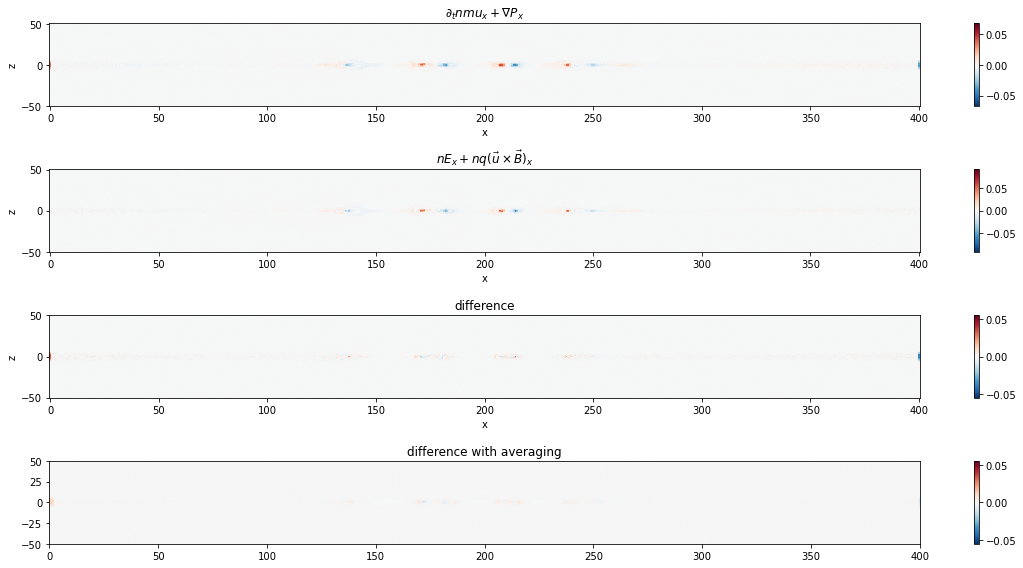

In [106]:
fig, axes = plt.subplots(4,1)

ex = h5p.getH5Grid('ex_ec', time)
n = h5p.getH5Grid('rho_nc_e', time)
jx = h5p.getH5Grid('jx_nc_e', time)
jy = h5p.getH5Grid('jy_nc_e', time)
jz = h5p.getH5Grid('jz_nc_e', time)
by = h5p.getH5Grid('hy_fc', time)
bz = h5p.getH5Grid('hz_fc', time)
px = h5p.getH5Grid('px_nc_e', time)
py = h5p.getH5Grid('py_nc_e', time)
pz = h5p.getH5Grid('pz_nc_e', time)

d_px_dt = (px - h5p.getH5Grid('px_nc_e', time-1)) / dt

d_px_dt = d_px_dt[:,0,:]

pxx = h5p.getH5Grid('txx_nc_e', time)
pzx = h5p.getH5Grid('tzx_nc_e', time)

d_pxx_dx = (np.diff(pxx[:,0,:], axis=1, prepend=0) + np.diff(pxx[:,0,:], axis=1, append=0)) / dx / 2
d_pzx_dz = (np.diff(pzx[:,0,:], axis=0, prepend=0) + np.diff(pzx[:,0,:], axis=0, append=0)) / dz / 2
div_px = d_pxx_dx + d_pzx_dz

lhs = (d_px_dt + div_px)

rhs = n*ex + jy*bz - jz*by
rhs = rhs[:,0,:]

lhs.plot(ax=axes[0], vmin=-rhs.max(), vmax=rhs.max(), cmap='RdBu_r')
axes[0].set_title(r'$\partial_t nmu_x + \nabla P_{x}$')


rhs.plot(ax=axes[1])#, vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
axes[1].set_title(r'$nE_x + nq(\vec{u} \times \vec{B})_x$')

total = lhs - rhs
total.plot(ax=axes[2], vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
axes[2].set_title('difference')

avg = averaging(total)
pcm5 = axes[3].pcolormesh(xlin, zlin, avg, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
fig.colorbar(pcm5, ax=axes[3])
axes[3].set_title('difference with averaging')
plt.tight_layout()

/ccs/home/johnd/.conda/envs/xarr_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(0.5, 1.0, 'difference with averaging')

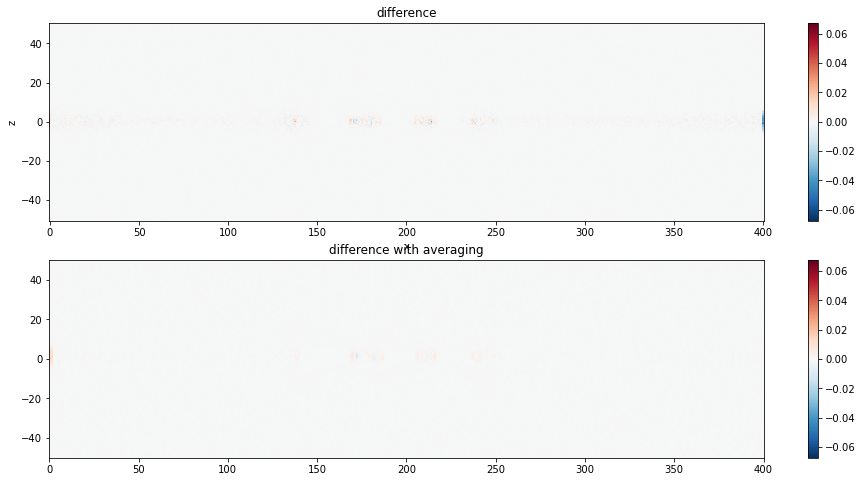

In [107]:
fig, axes = plt.subplots(2,1)

total.plot(ax=axes[0], vmin=-rhs.max(), vmax=rhs.max(), cmap='RdBu_r')
axes[0].set_title('difference')

pcm5 = axes[1].pcolormesh(xlin, zlin, avg, vmin=-rhs.max(), vmax=rhs.max(), cmap='RdBu_r')
fig.colorbar(pcm5, ax=axes[1])
axes[1].set_title('difference with averaging')

Loading pz_nc_e from File: pfd.002800.xdmf
Loading tzx_nc_e from File: pfd.002801.xdmf
Loading tzz_nc_e from File: pfd.002801.xdmf
Loading ez_ec from File: pfd.002801.xdmf
Loading hx_fc from File: pfd.002801.xdmf


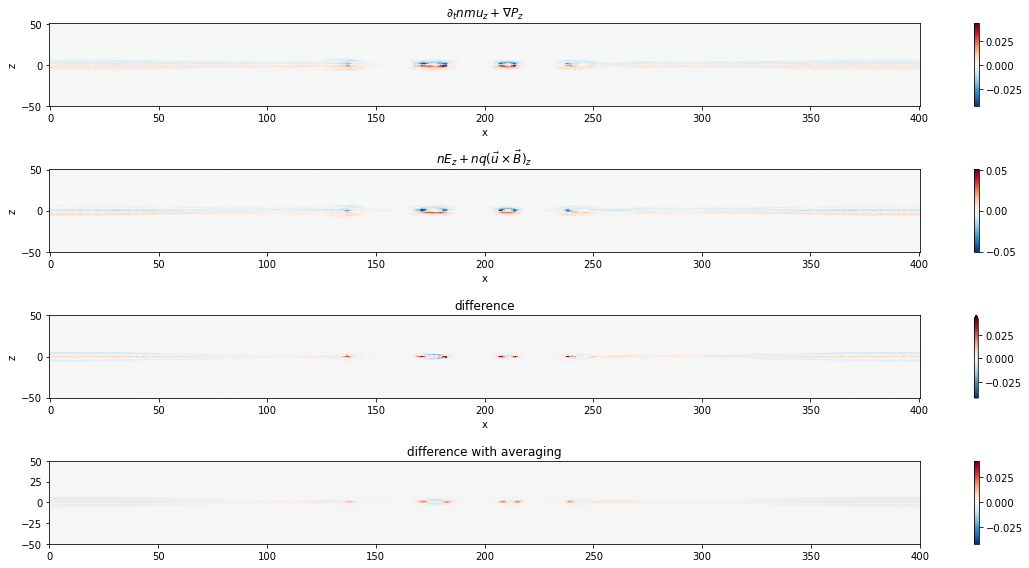

In [126]:
fig, axes = plt.subplots(4,1)

d_pz_dt = (pz - h5p.getH5Grid('pz_nc_e', time-1)) / dt
d_pz_dt = d_pz_dt[:,0,:]

pxz = h5p.getH5Grid('tzx_nc_e', time)
pzz = h5p.getH5Grid('tzz_nc_e', time)

d_pxz_dx = np.diff(pxz[:,0,:], axis=1, prepend=0) /dx# + np.diff(pxz[:,0,:], axis=1, append=0)) / dx / 2
d_pzz_dz = np.diff(pzz[:,0,:], axis=0, prepend=0) /dz# + np.diff(pzz[:,0,:], axis=0, append=0)) / dz / 2
div_pz = d_pxz_dx + d_pzz_dz

lhs = (d_pz_dt + div_pz)

lhs.plot(ax=axes[0])
axes[0].set_title(r'$\partial_t nmu_z + \nabla P_{z}$')

ez = h5p.getH5Grid('ez_ec', time)
bx = h5p.getH5Grid('hx_fc', time)

# Ez = ec_to_nc(ez[:,0,:], dim='z')
# Bx = fc_to_nc(bx[:,0,:], dim='x')
# By = fc_to_nc(by[:,0,:], dim='y')


rhs = n*ez + jx*by - jy*bx
rhs = rhs[:,0,:]
rhs.plot(ax=axes[1])#, vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
# rhs = n.data[:,0,:]*Ez + jx.data[:,0,:]*By - jy.data[:,0,:]*Bx
# pcm3 = axes[1].pcolormesh(rhs,cmap='RdBu_r')
# fig.colorbar(pcm3, ax=axes[1])
axes[1].set_title(r'$nE_z + nq(\vec{u} \times \vec{B})_z$')

total = lhs - rhs
total.plot(ax=axes[2], vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
# pcm4 = axes[2].pcolormesh(total, vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
# fig.colorbar(pcm4, ax=axes[2])
axes[2].set_title('difference')

avg = averaging(total)

pcm5 = axes[3].pcolormesh(xlin, zlin, avg, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
fig.colorbar(pcm5, ax=axes[3])
axes[3].set_title('difference with averaging')

plt.tight_layout()

Text(0.5, 1.0, 'difference with averaging')

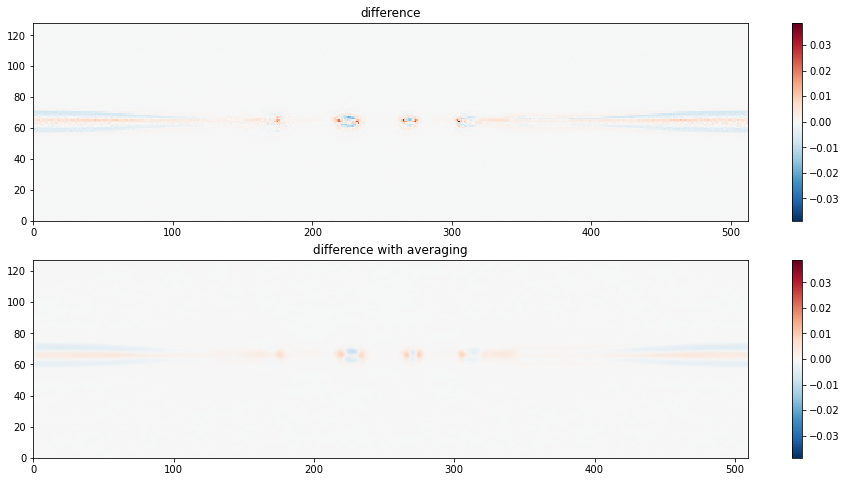

In [115]:
fig, axes = plt.subplots(2,1)
o=1 #offset
pcm1 = axes[0].pcolormesh(lhs-rhs, vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[0])
axes[0].set_title('difference')
pcm2 = axes[1].pcolormesh(averaging(averaging(lhs[:,:-o]-rhs[:,o:])), cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
fig.colorbar(pcm2, ax=axes[1])
axes[1].set_title('difference with averaging')

Loading txx_nc_e from File: pfd.002801.xdmf
Loading txx_nc_e from File: pfd.002800.xdmf
Loading qxxx_nc_e from File: pfd.002801.xdmf
Loading qxxz_nc_e from File: pfd.002801.xdmf
Loading txy_nc_e from File: pfd.002801.xdmf
Loading tzx_nc_e from File: pfd.002801.xdmf


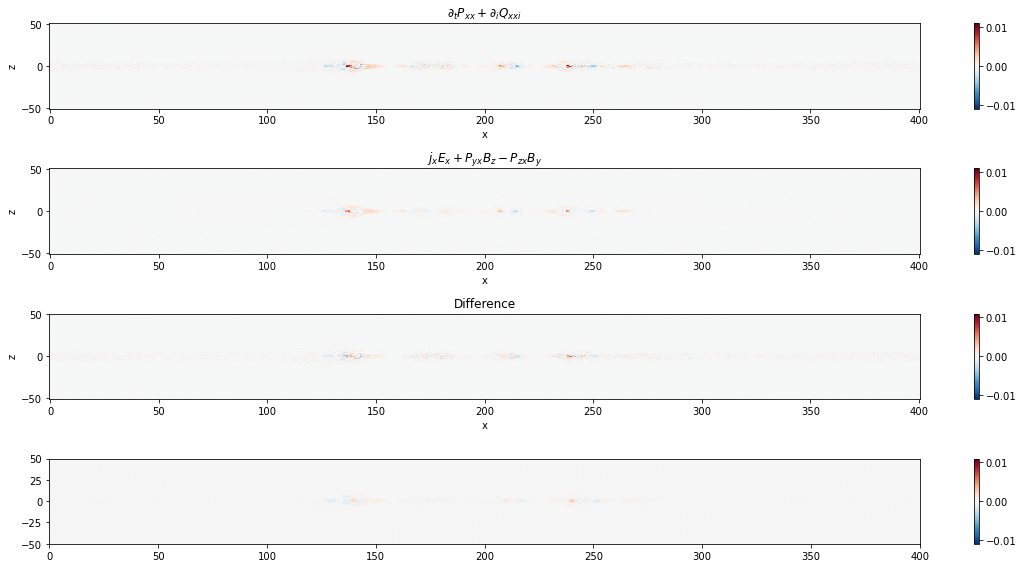

In [120]:
fig, axes = plt.subplots(4,1)

pxx1 = h5p.getH5Grid('txx_nc_e', time)
pxx2 = h5p.getH5Grid('txx_nc_e', time-1)

d_pxx_dt = (pxx1 - pxx2)/dt

qxxx = h5p.getH5Grid('qxxx_nc_e', time)
qxxz = h5p.getH5Grid('qxxz_nc_e', time)

d_qxxx_dx = np.diff(qxxx[:,0,:], axis=1, prepend=0) /dx# + np.diff(qxxx[:,0,:], axis=1, append=0)) / dx / 2
d_qxxz_dz = np.diff(qxxz[:,0,:], axis=0, prepend=0) /dz#+ np.diff(qxxz[:,0,:], axis=1, append=0)) / dz / 2
div_qxx = d_qxxx_dx + d_qxxz_dz

lhs = d_pxx_dt[:,0,:] + div_qxx
lhs.plot(ax=axes[0])
axes[0].set_title(r'$\partial_t P_{xx} + \partial_i Q_{xxi} $')

pyx = h5p.getH5Grid('txy_nc_e', time)
pzx = h5p.getH5Grid('tzx_nc_e', time)

rhs = jx * ex - (pyx * bz - pzx * by)
rhs.plot(ax=axes[1], vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
axes[1].set_title(r'$j_xE_x + P_{yx}B_z - P_{zx}B_y$')

total = lhs - rhs
total.plot(ax=axes[2], vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
axes[2].set_title('Difference')

avg = averaging(total[:,:,0])
pcm = axes[3].pcolormesh(xlin, zlin, avg, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
fig.colorbar(pcm, ax=axes[3])
plt.tight_layout()

Loading tzz_nc_e from File: pfd.002801.xdmf
Loading tzz_nc_e from File: pfd.002800.xdmf
Loading qzzx_nc_e from File: pfd.002801.xdmf
Loading qzzz_nc_e from File: pfd.002801.xdmf
Loading tzx_nc_e from File: pfd.002801.xdmf
Loading tyz_nc_e from File: pfd.002801.xdmf


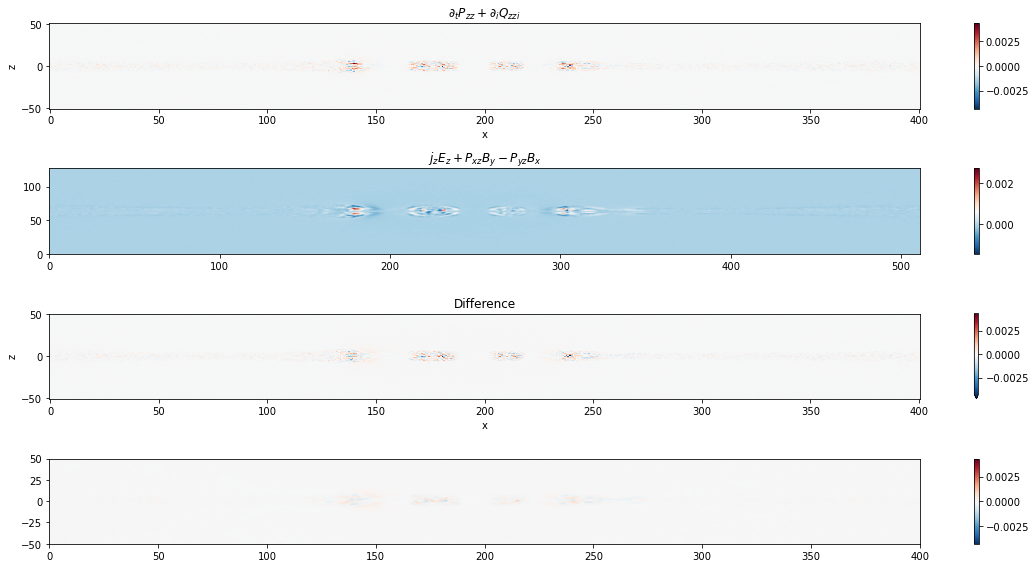

In [123]:
fig, axes = plt.subplots(4,1)

pzz1 = h5p.getH5Grid('tzz_nc_e', time)
pzz2 = h5p.getH5Grid('tzz_nc_e', time-1)

d_pzz_dt = (pzz1 - pzz2)/dt

qzzx = h5p.getH5Grid('qzzx_nc_e', time)
qzzz = h5p.getH5Grid('qzzz_nc_e', time)

d_qzzx_dx = np.diff(qzzx[:,0,:], axis=1, prepend=0) /dx# + np.diff(qzzx[:,0,:], axis=1, append=0)) / dx / 2
d_qzzz_dz = np.diff(qzzz[:,0,:], axis=0, prepend=0) /dz#+ np.diff(qzzz[:,0,:], axis=1, append=0)) / dz / 2
div_qzz = d_qzzx_dx + d_qzzz_dz

lhs = d_pzz_dt[:,0,:] + div_qzz
lhs.plot(ax=axes[0])
axes[0].set_title(r'$\partial_t P_{zz} + \partial_i Q_{zzi} $')

pxz = h5p.getH5Grid('tzx_nc_e', time)
pyz = h5p.getH5Grid('tyz_nc_e', time)

# rhs = jz * ez - (pxz * by - pyz * bx)
# rhs.plot(ax=axes[1])#, vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
rhs = jz.data[:,0,:] * Ez - (pxz.data[:,0,:] * By - pyz.data[:,0,:] * Bx)
pcm1 = axes[1].pcolormesh(rhs, cmap='RdBu_r', shading='gouraud')
fig.colorbar(pcm1, ax=axes[1])
axes[1].set_title(r'$j_zE_z + P_{xz}B_y - P_{yz}B_x$')

total = lhs - rhs
total.plot(ax=axes[2], vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
axes[2].set_title('Difference')

avg = averaging(total)
pcm = axes[3].pcolormesh(xlin, zlin, avg, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
fig.colorbar(pcm, ax=axes[3])
plt.tight_layout()

In [11]:
h5p.attributes

['ex_ec',
 'ey_ec',
 'ez_ec',
 'div_e_err_nc',
 'hx_fc',
 'hy_fc',
 'hz_fc',
 'div_b_err_cc',
 'tcax_ec',
 'tcay_ec',
 'tcaz_ec',
 'rhob_nc',
 'jx_ec',
 'jy_ec',
 'jz_ec',
 'rhof_nc',
 'jx_nc_e',
 'jy_nc_e',
 'jz_nc_e',
 'rho_nc_e',
 'px_nc_e',
 'py_nc_e',
 'pz_nc_e',
 'ke_nc_e',
 'txx_nc_e',
 'tyy_nc_e',
 'tzz_nc_e',
 'tyz_nc_e',
 'tzx_nc_e',
 'txy_nc_e',
 'qxxx_nc_e',
 'qyyy_nc_e',
 'qzzz_nc_e',
 'qxxy_nc_e',
 'qyyz_nc_e',
 'qzzx_nc_e',
 'qxxz_nc_e',
 'qyyx_nc_e',
 'qzzy_nc_e',
 'qxyz_nc_e',
 'jx_nc_i',
 'jy_nc_i',
 'jz_nc_i',
 'rho_nc_i',
 'px_nc_i',
 'py_nc_i',
 'pz_nc_i',
 'ke_nc_i',
 'txx_nc_i',
 'tyy_nc_i',
 'tzz_nc_i',
 'tyz_nc_i',
 'tzx_nc_i',
 'txy_nc_i',
 'qxxx_nc_i',
 'qyyy_nc_i',
 'qzzz_nc_i',
 'qxxy_nc_i',
 'qyyz_nc_i',
 'qzzx_nc_i',
 'qxxz_nc_i',
 'qyyx_nc_i',
 'qzzy_nc_i',
 'qxyz_nc_i']

Loading rho_nc_e from File: pfd.005700.xdmf
Loading rho_nc_e from File: pfd.005600.xdmf


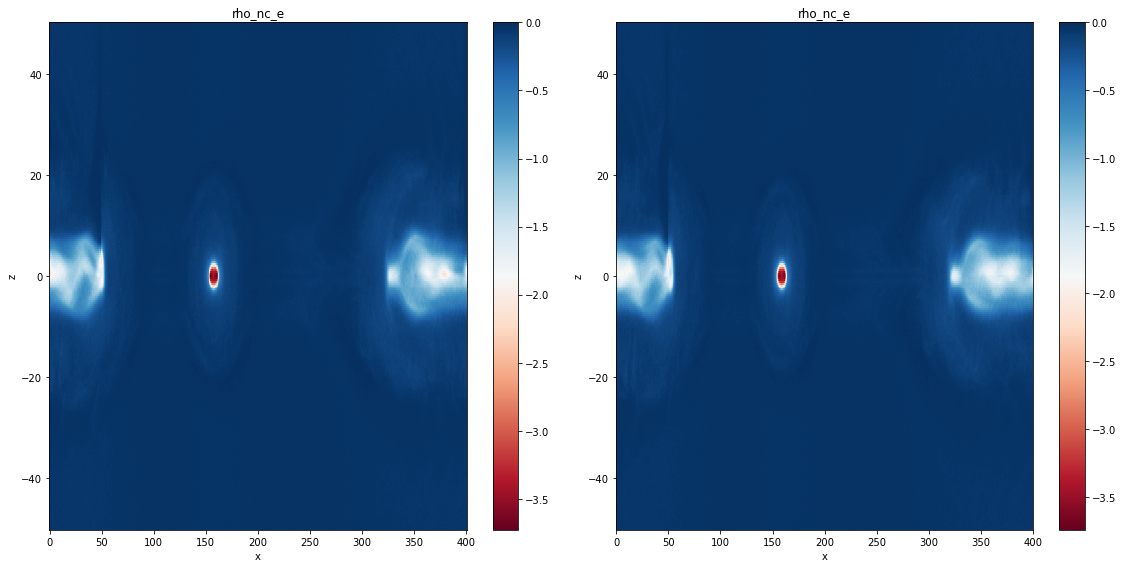

In [17]:
fieldGrid(root, ['rho_nc_e'], [-1,-2], zrange=(None,None), timeAveraged=False)